In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from kLSTM import *
from sklearn.metrics import accuracy_score

def train(model, device, train_loader, optimizer, config, epoch):
    model.train()   # set model in training mode
    losses = []
    scores = []

    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device)
        X = torch.squeeze(X, 1)  # remove grey-level channel of MNIST

        optimizer.zero_grad()
        output, layer_z_T, layer_qz_T, layer_h_T, _ = model(X, config.tau, is_training=True)
        '''layer_qz_T= qz_T in last layer'''

        # computing entropy loss
        entropy = - layer_qz_T * torch.log(layer_qz_T + 1e-20)
        loss2 = torch.mean(torch.sum(entropy, (1, 2)))

        # define total loss
        if config.obj == 'ER':
            loss = F.cross_entropy(output, y) - config.beta * loss2
        elif config.obj == 'VB':
            loss = F.cross_entropy(output, y) - loss2
        elif config.obj == 'MLE':
            loss = F.cross_entropy(output, y)

        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # convert output -> y_pred
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()

        # # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip)
        for p in model.parameters():
            p.data.add_(-config.lr, p.grad.data)

        optimizer.step()

        # show information
        if batch_idx % config.log_interval == 0:
            print("Learning rate: {:.4f}, Temperature: {:.3f}\n".format(config.lr, config.tau))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores


def validation(model, device, test_loader, config):
    model.eval()   # set model in testing mode
    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)
            X = torch.squeeze(X, 1)  # remove grey-level channel for MNIST

            output, layer_z_T, layer_qz_T, layer_h_T, _ = model(X, config.tau, is_training=False)
            '''layer_qz_T: last layer qz_T'''

            # computing entropy loss
            entropy = - layer_qz_T * torch.log(layer_qz_T + 1e-20)
            entropy = entropy.sum(1).sum(1).sum()

            # define total loss
            if config.obj == 'ER':
                loss = F.cross_entropy(output, y) - config.beta * entropy
            elif config.obj == 'VB':
                loss = F.cross_entropy(output, y) - entropy
            elif config.obj == 'MLE':
                loss = F.cross_entropy(output, y)

            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # to compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show info
    print('\nTest set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), test_loss, 100 * test_score))

    return test_loss, test_score

### set training parameters

In [2]:
class Config(object):
    init_scale = 0.1
    epochs = 10
    batch_size = 150
    display_step = 100
    lr = 1e-3
    clip = 0.25         # gradient clip threshold to avoid grdient explosion
    vocab_size = 10000
    tau0 = 5.0          # initial temperature
    anneal_rate = 0.1
    min_temp = 0.1
    beta = 0.001
    log_interval = 100
    obj = 'ER'          # define MRNN loss objective, select: 'MLE','VB','ER'

    # Network Parameters
    input_size = 28
    hidden_size = 128
    num_class = 10
    T = 28              # timesteps of data
    num_layers = 3
    K = 4               # LSTM numbers

config = Config()

# output
output_folder = './outputs/'

### use MNIST dataset

In [3]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./MNIST/', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=False)

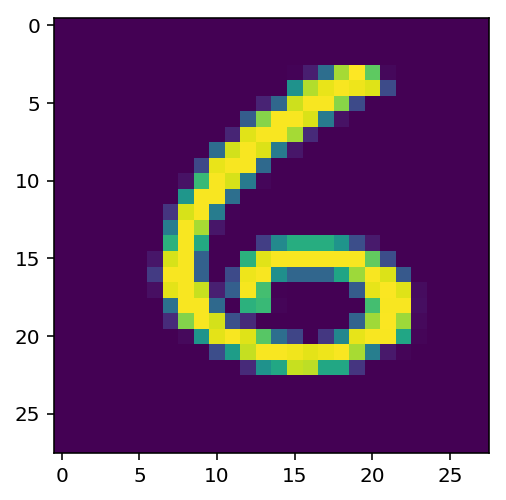

In [4]:
X, y = next(iter(train_loader))

plt.figure()
plt.imshow(X[0, 0, :, :])
plt.show()

### start training

In [5]:
# check GPU devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# set dataloader parameters
params = {'batch_size': config.batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# create model
mrnn = LSTM(cell_class=LSTMCell, input_size=config.T, hidden_size=config.hidden_size,
            output_size=config.num_class, num_layers=config.num_layers, k_cells=config.K, use_bias=True, dropout_prob=0.5).to(device)

optimizer = torch.optim.Adam(mrnn.parameters(), lr=config.lr)   # optimize all cnn parameters

# Training cycle
for epoch in range(config.epochs):
    avg_cost = 0.

    # adjust Gumbel softmax temp
    config.tau = np.maximum(config.tau0 * np.exp(-config.anneal_rate * epoch), config.min_temp)
    # training model
    train_losses, train_scores = train(mrnn, device, train_loader, optimizer, config, epoch)

for epoch in range(1):
    # model validation
    print('-' * 80); print('validating'); print('-' * 80)
    epoch_test_loss, epoch_test_score = validation(mrnn, device, test_loader, config)

LSTM cell parameters reseted!
LSTM cell parameters reseted!
LSTM cell parameters reseted!
Learning rate: 0.0010, Temperature: 5.000

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.260281, Accu: 10.67%
Learning rate: 0.0010, Temperature: 5.000

Train Epoch: 0 [15000/60000 (25%)]	Loss: 1.102903, Accu: 56.00%
Learning rate: 0.0010, Temperature: 5.000

Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.637312, Accu: 78.67%
Learning rate: 0.0010, Temperature: 5.000

Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.557475, Accu: 82.67%
Learning rate: 0.0010, Temperature: 4.524

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.335828, Accu: 89.33%
Learning rate: 0.0010, Temperature: 4.524

Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.214766, Accu: 91.33%
Learning rate: 0.0010, Temperature: 4.524

Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.162352, Accu: 96.00%
Learning rate: 0.0010, Temperature: 4.524

Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.125817, Accu: 95.33%
Learning rate: 0.0010, Temperature: 4.094

Train Epoch: 2 [0/600

## Display some images

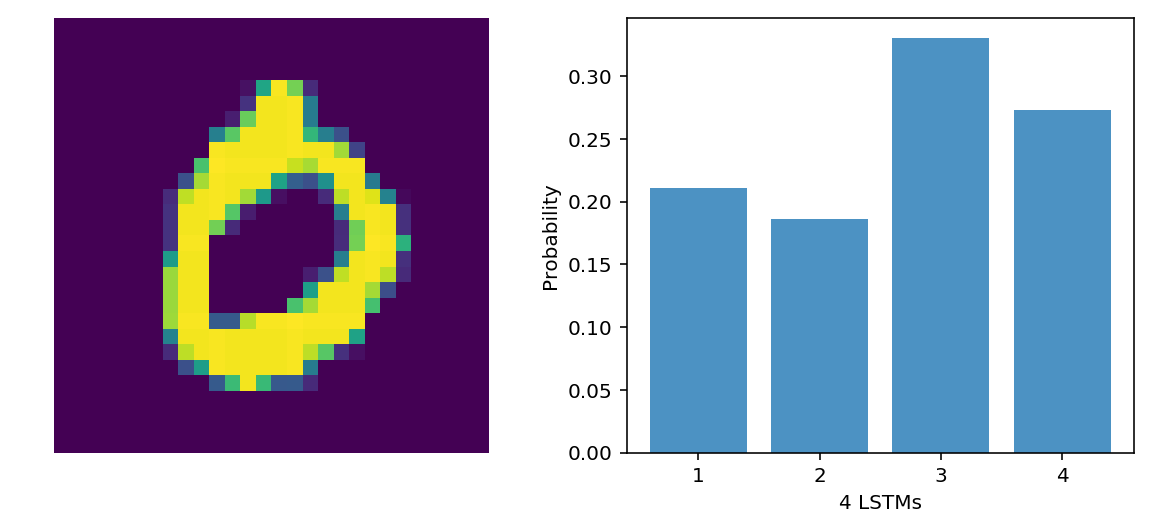

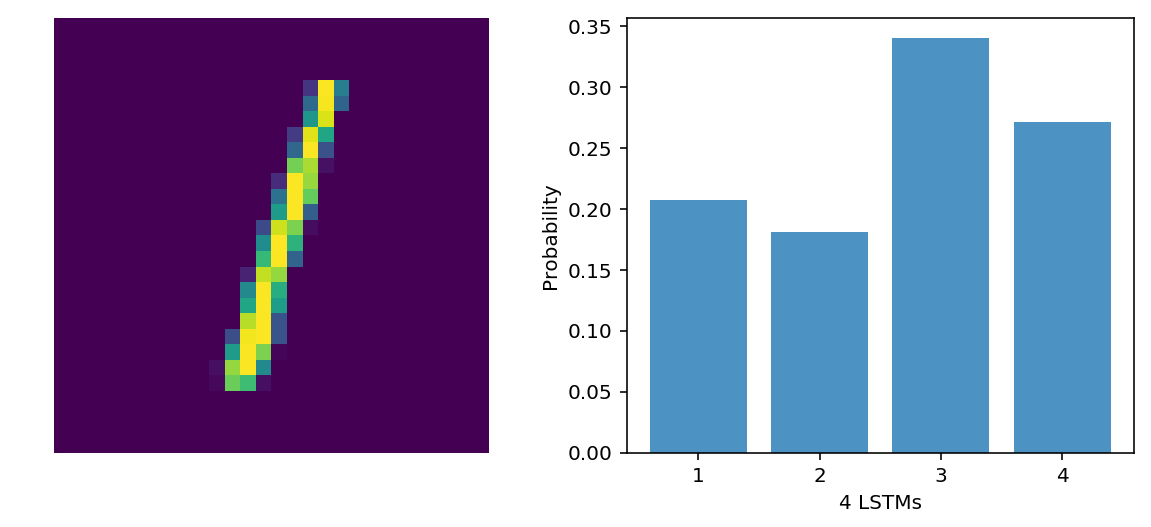

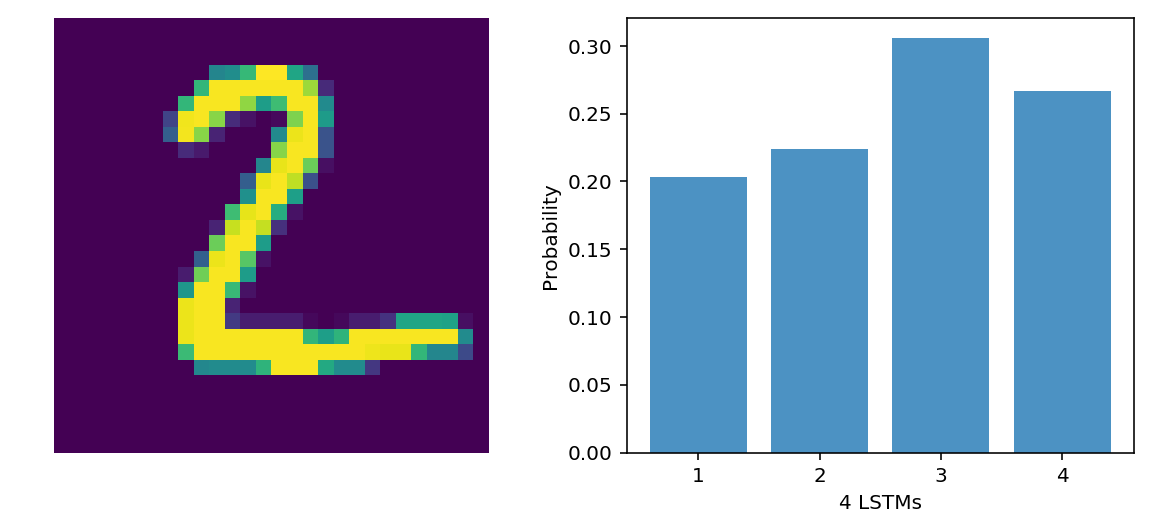

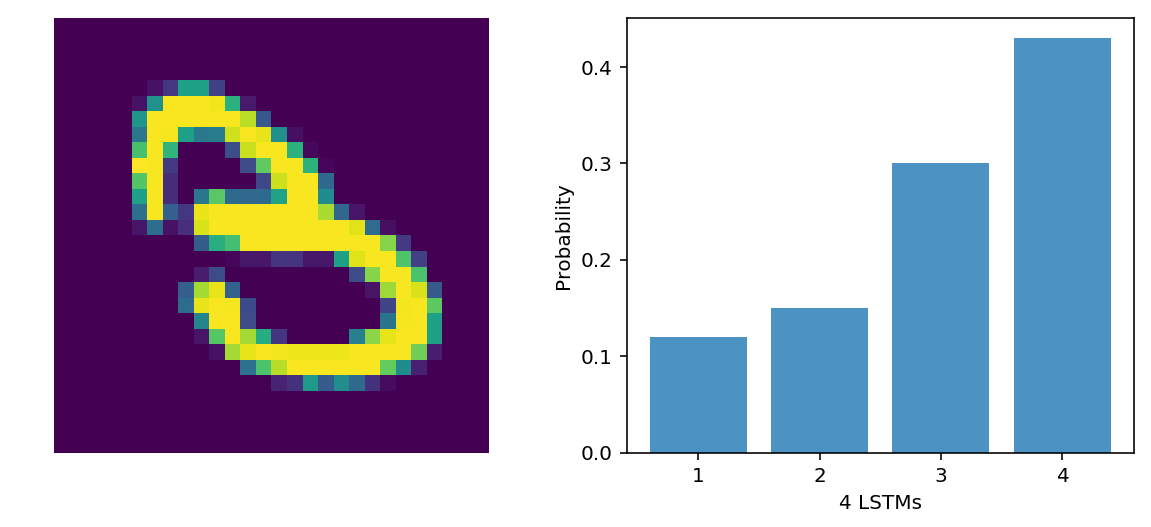

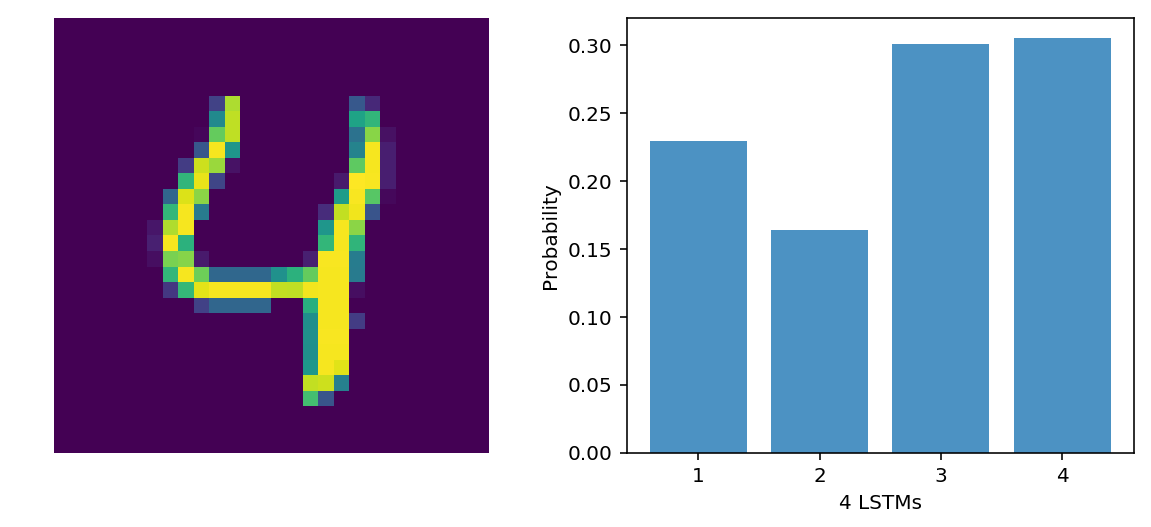

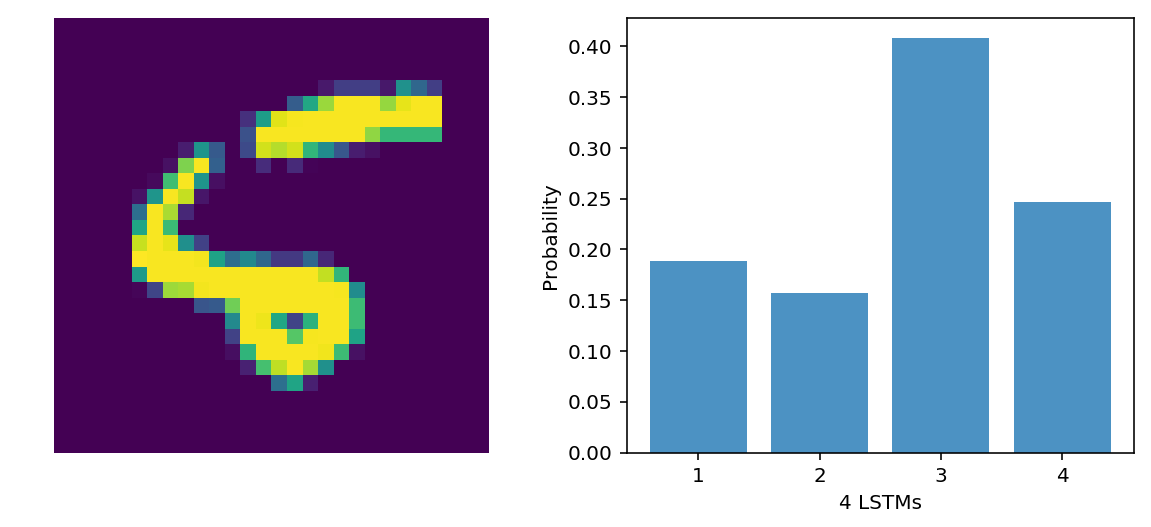

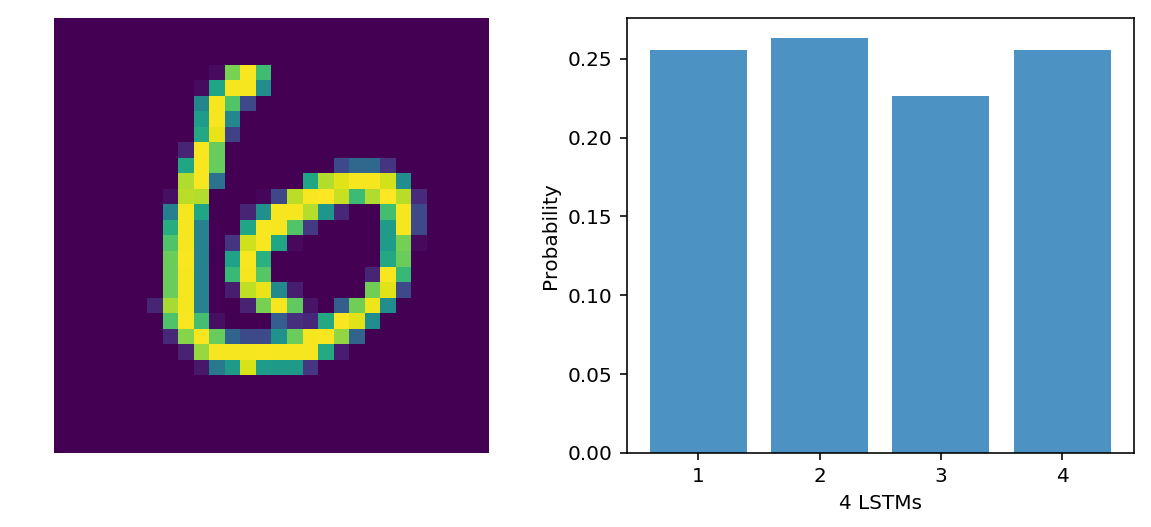

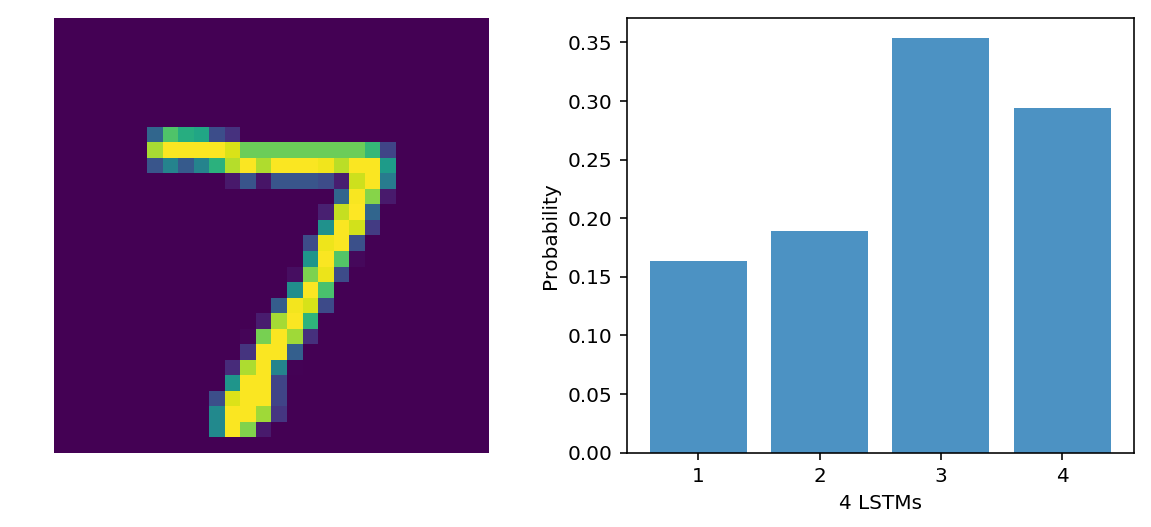

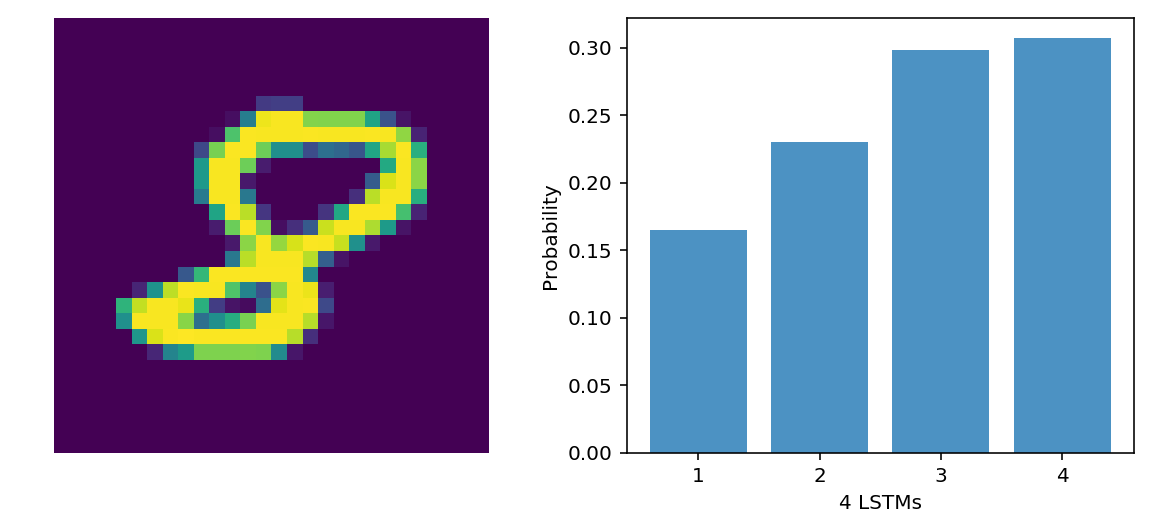

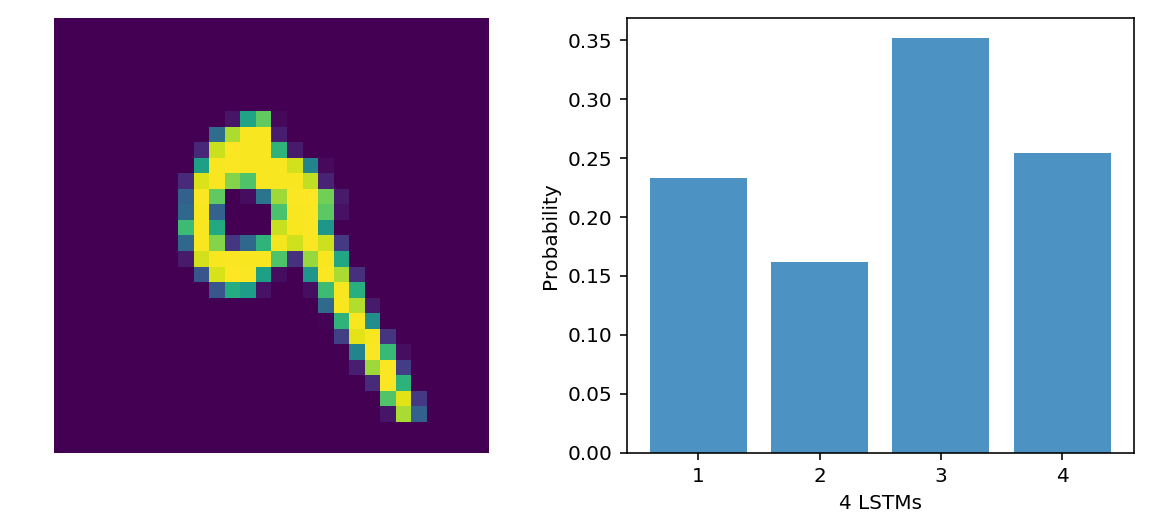

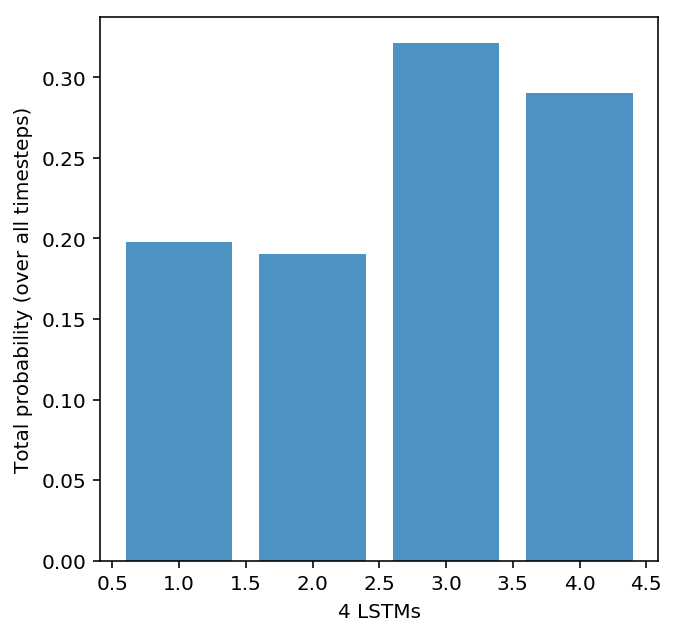

In [6]:
total_prob = 0
eval_config = Config()
eval_config.batch_size = 1
eval_config.T = 1

X = test_loader.dataset.test_data.to(device)
y = test_loader.dataset.test_labels.to(device)

for i in range(eval_config.num_class):
    # select samples of label y=i
    X_i, y_i = X[y == i, :].float()/255.0, y[y == i]

    eval_config.batch_size = X_i.shape[0]
    with torch.no_grad():
        output, layer_z_T, layer_qz_T, layer_h_T, _ = mrnn(X_i, eval_config.tau0, is_training=False)
    
    # compute probability of LSTM usage (integrating) over time and selected samples
    prob = torch.einsum('ijk->k', (layer_z_T,)) / torch.sum(layer_z_T)
    prob = prob.data.cpu().numpy()
    total_prob += prob

    # plot image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(X_i.data.cpu()[0])
    plt.axis('off')

    # plot probability(k LSTM)
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(eval_config.K) + 1, prob, alpha=0.8)
    plt.xlabel('{} LSTMs'.format(eval_config.K))
    plt.ylabel('Probability')
    # plt.savefig(os.path.join(output_folder, 'digit{}_transition.png'.format(i)), dpi=600)
    plt.show()

# plot total probability (over all classes [labels])
total_prob = total_prob / eval_config.num_class
plt.figure(figsize=(5, 5))
plt.bar(np.arange(eval_config.K) + 1, total_prob, alpha=0.8)
plt.xlabel('{} LSTMs'.format(eval_config.K))
plt.ylabel('Total probability (over all timesteps)')
plt.show()

## Plot $z(t)$ and $q_z(t)$ , where $t \in [0, T]$

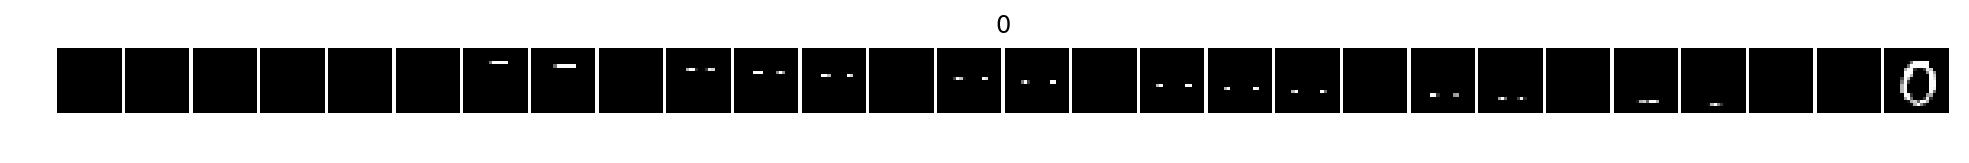

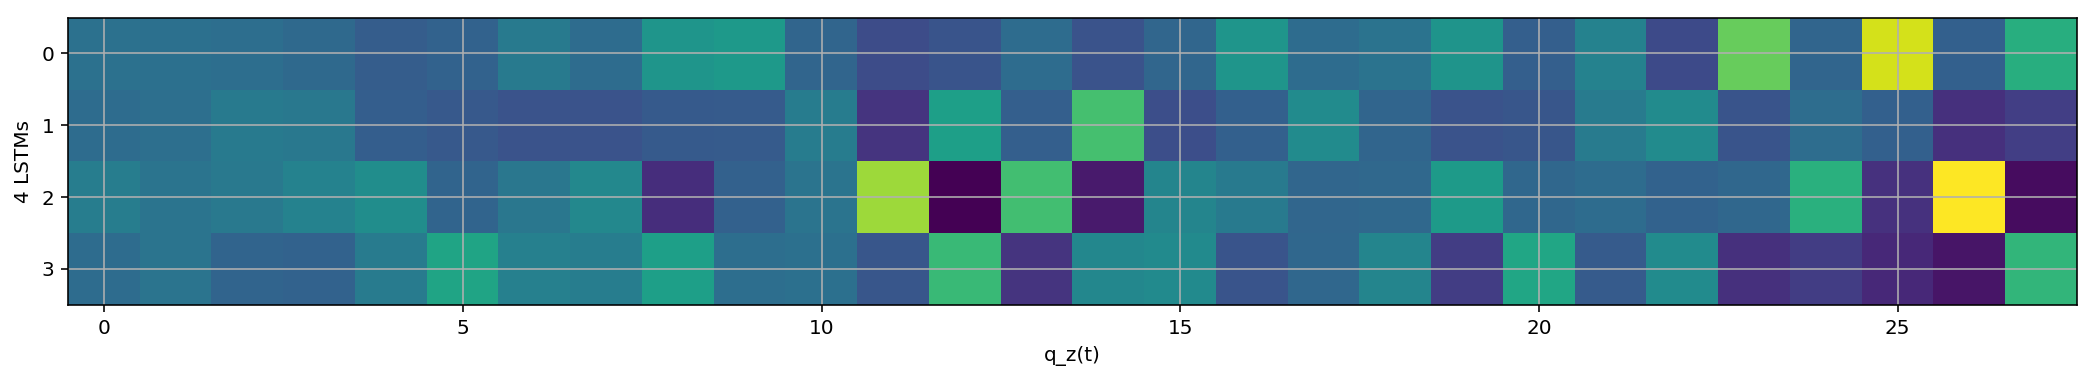

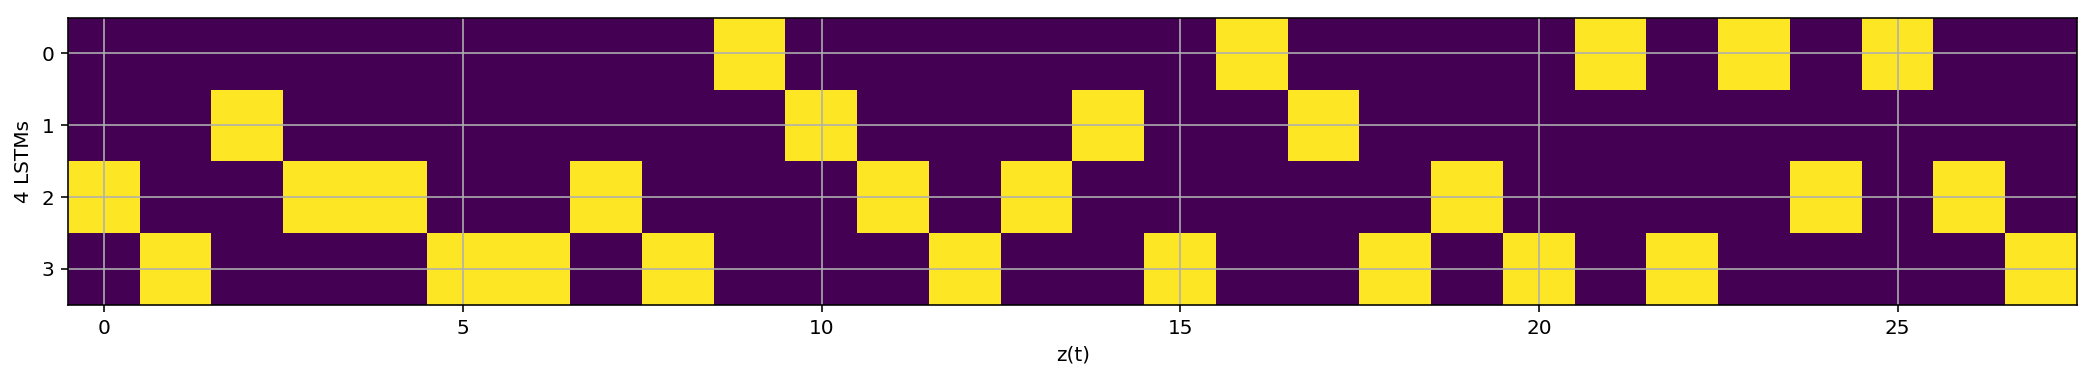

--------------------------------------------------------------------------------


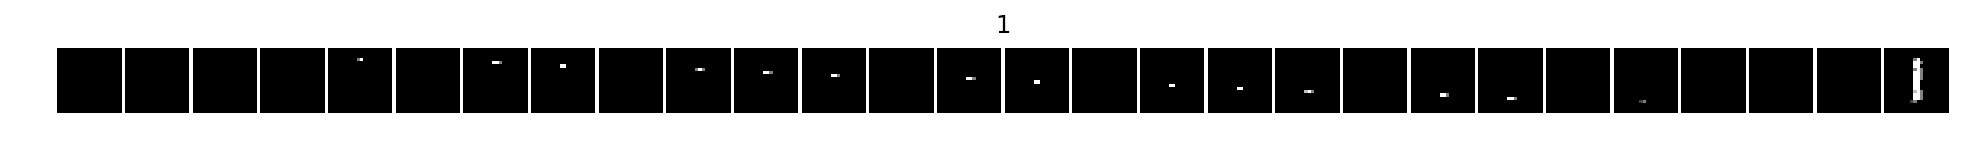

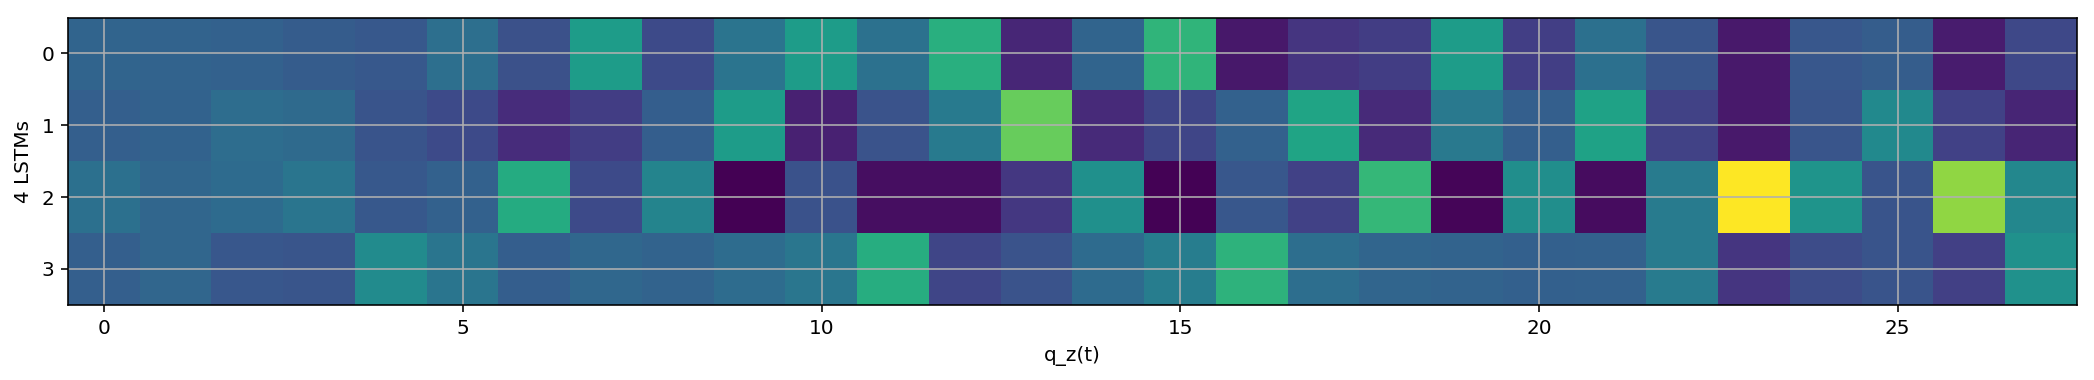

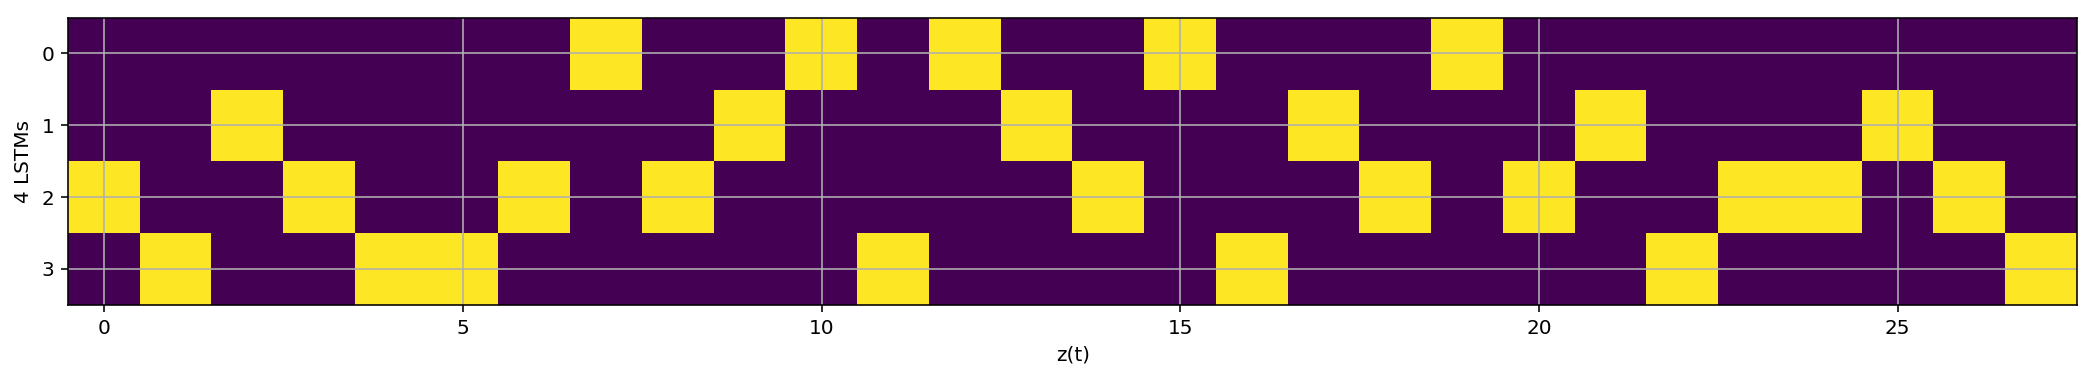

--------------------------------------------------------------------------------


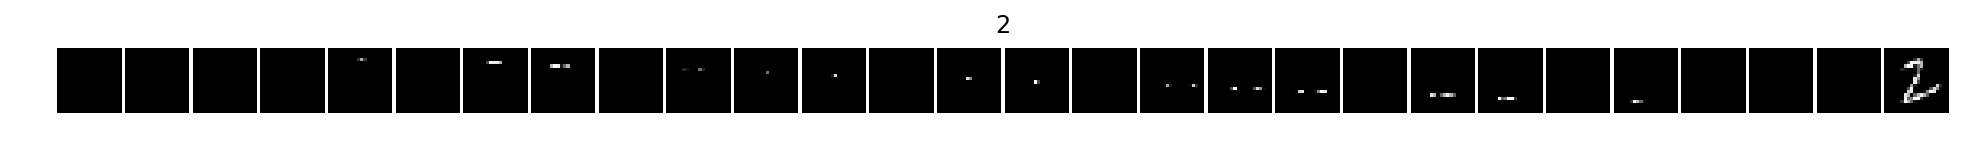

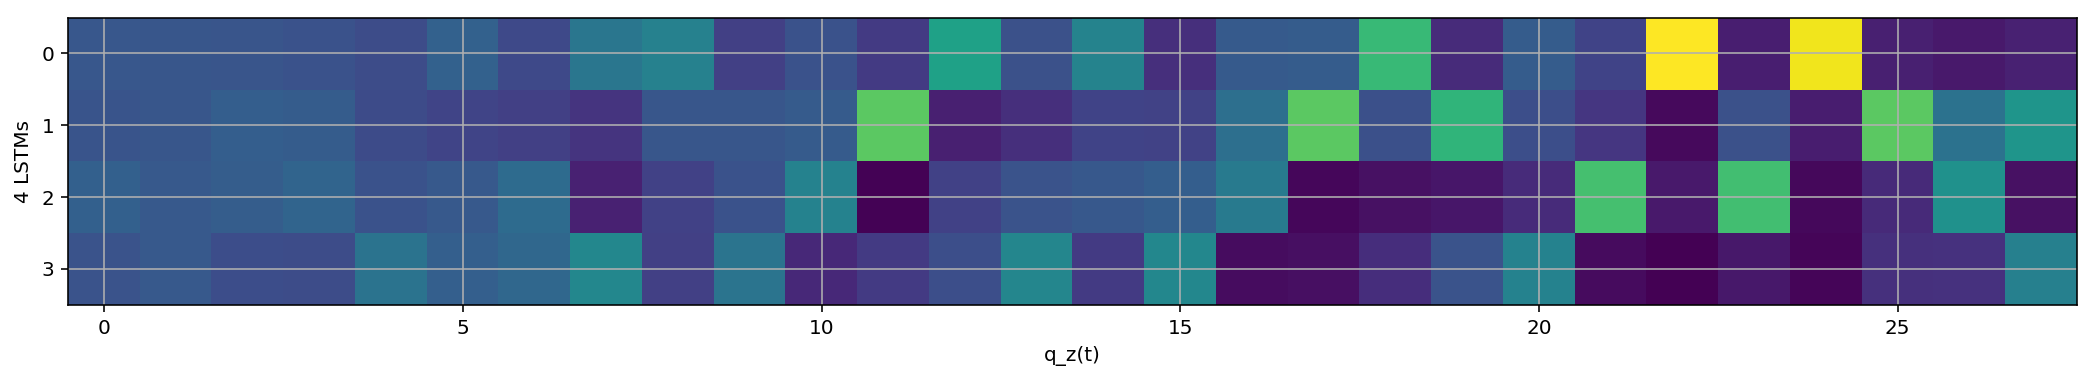

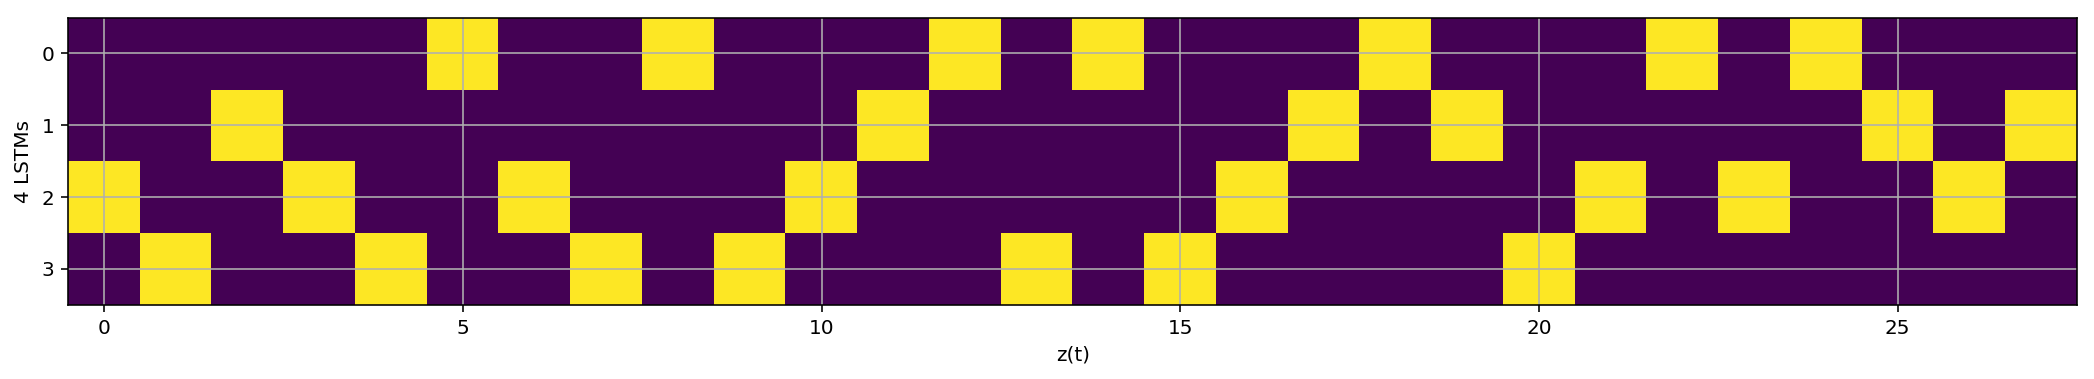

--------------------------------------------------------------------------------


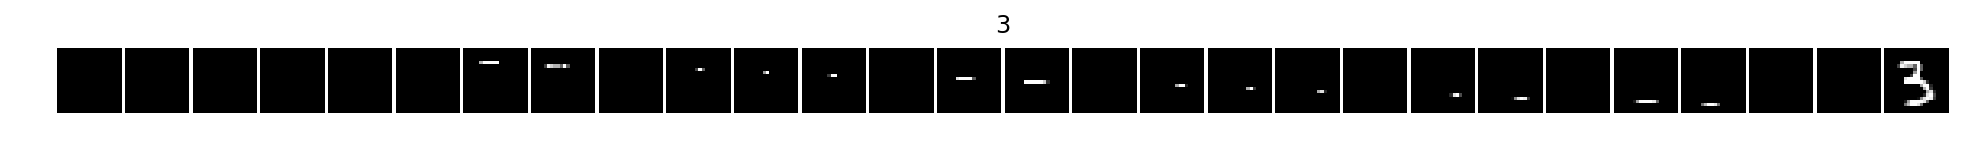

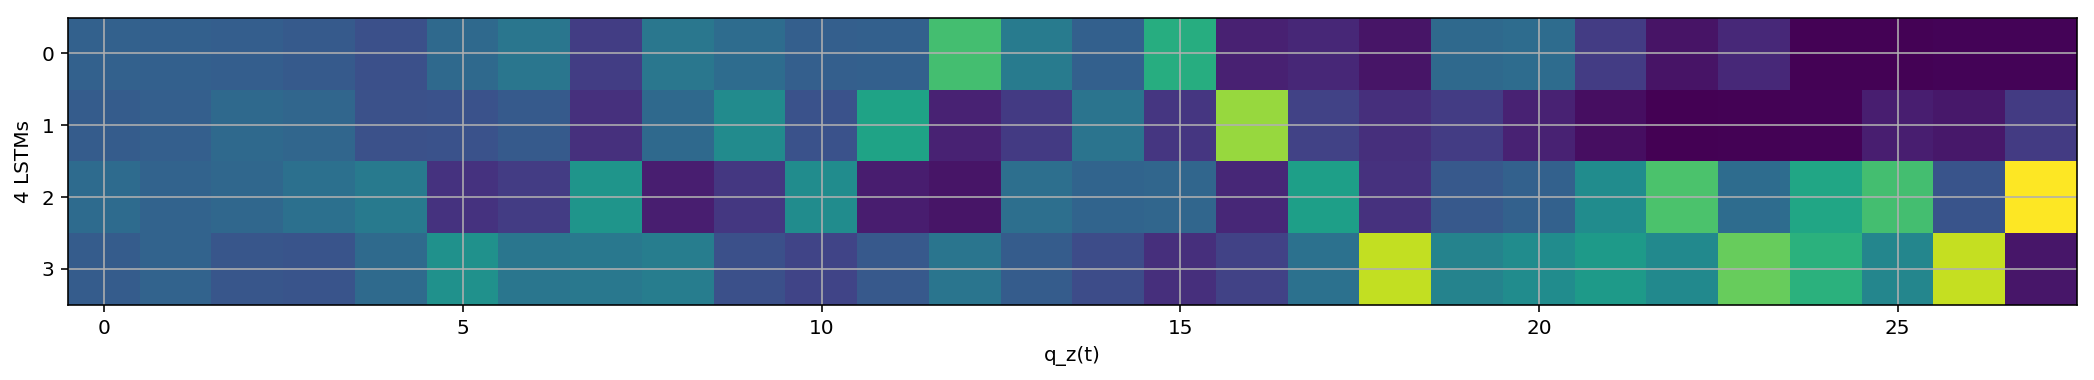

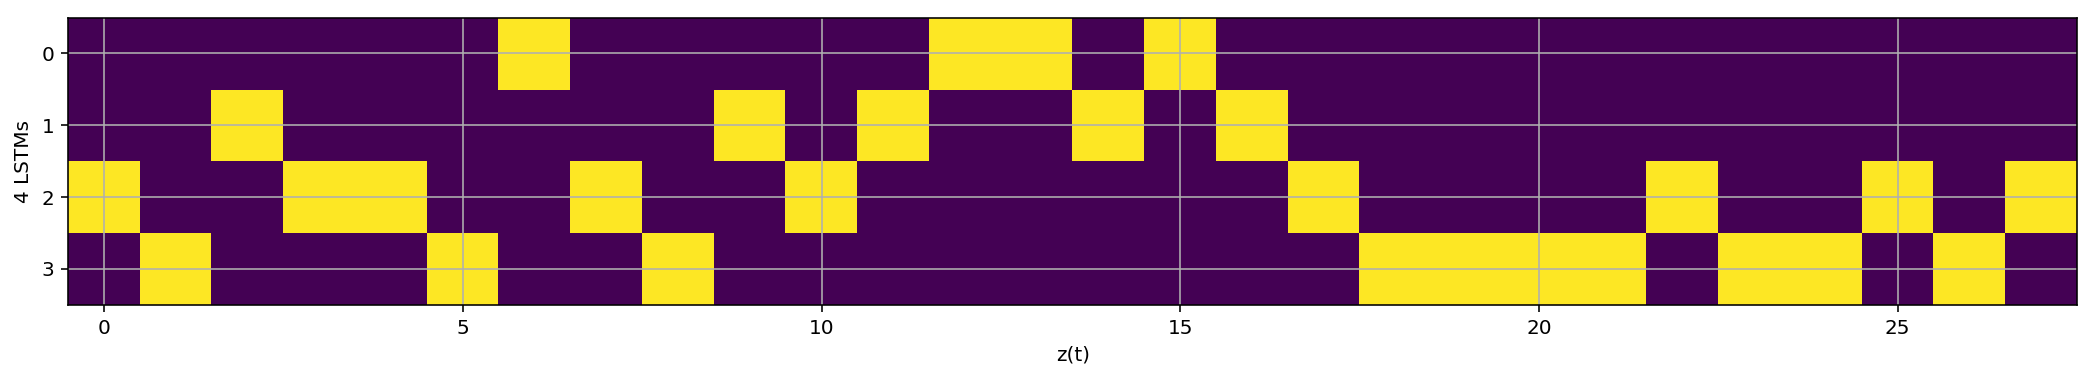

--------------------------------------------------------------------------------


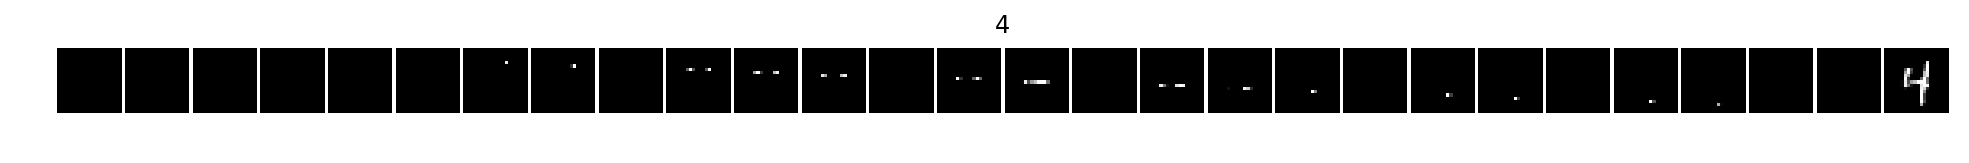

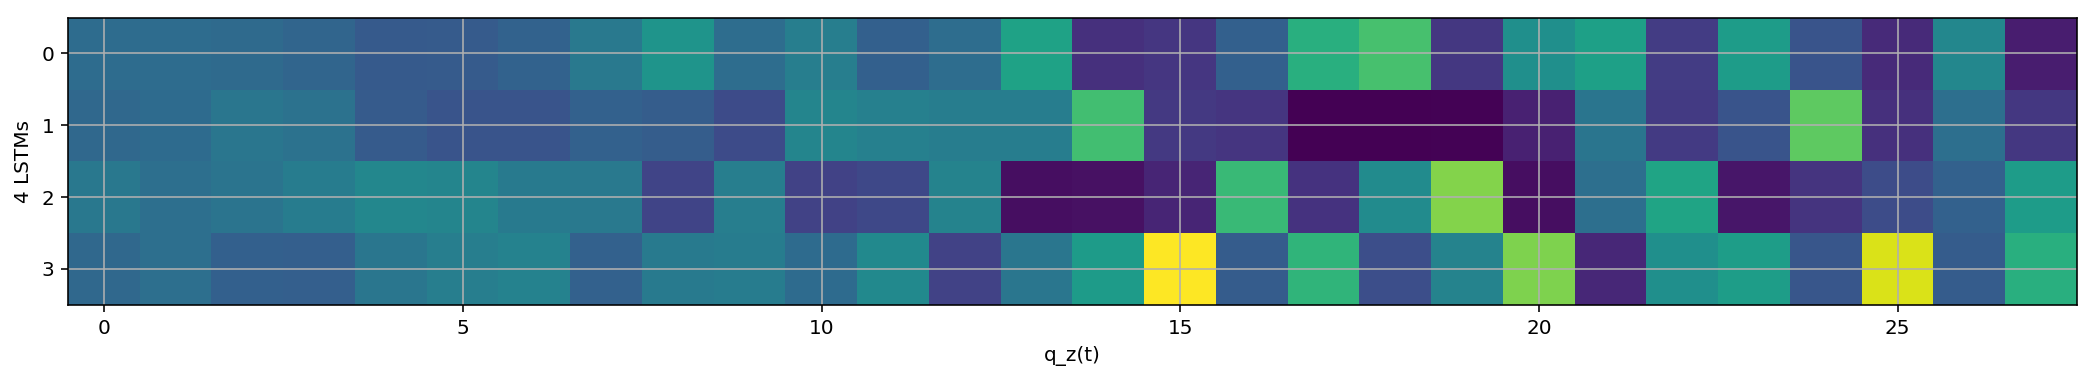

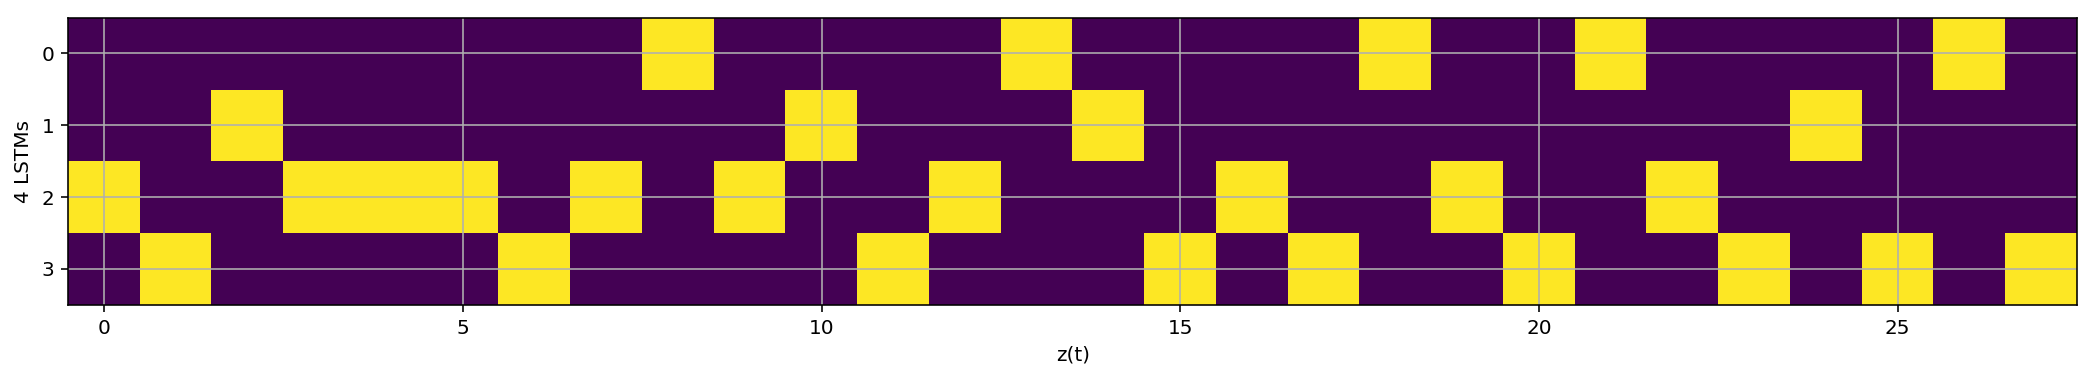

--------------------------------------------------------------------------------


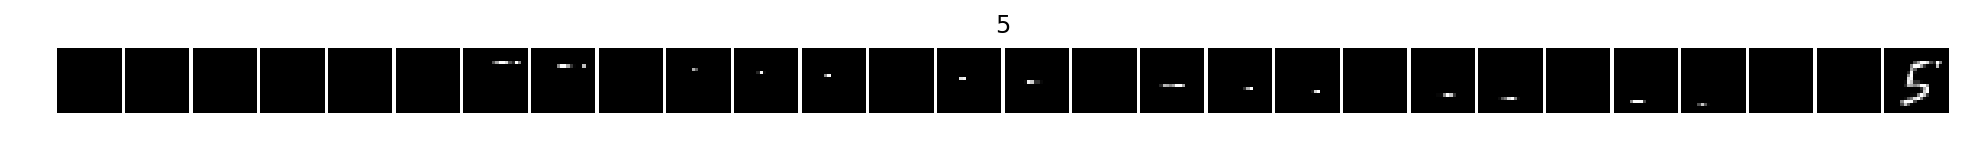

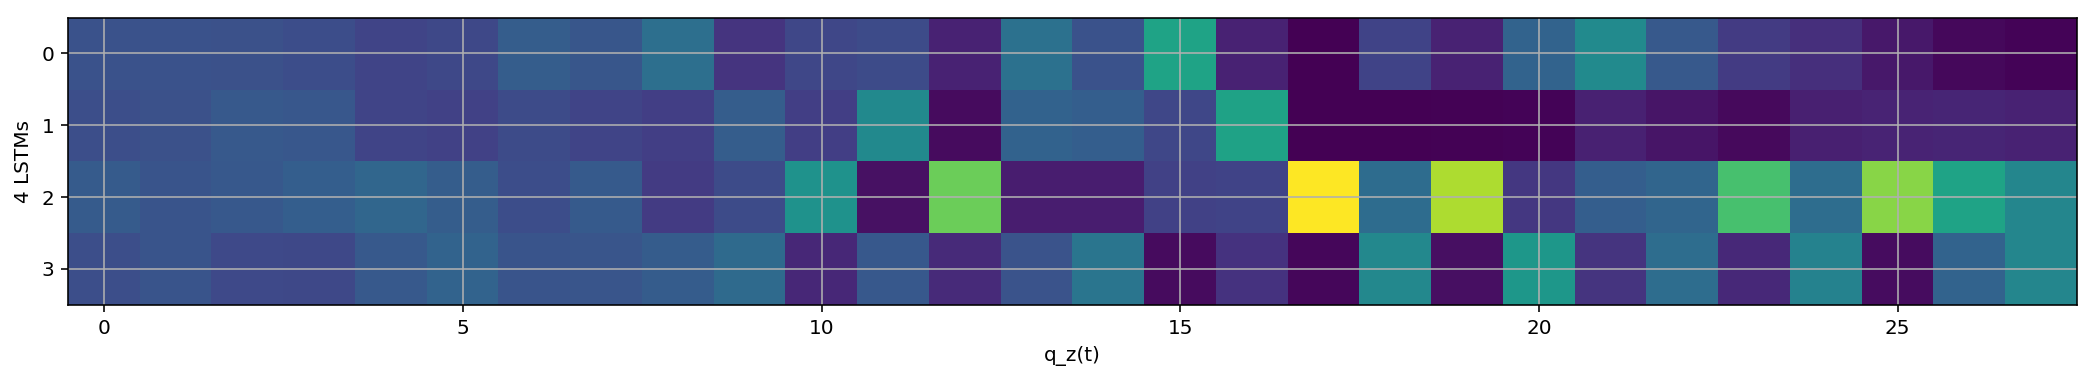

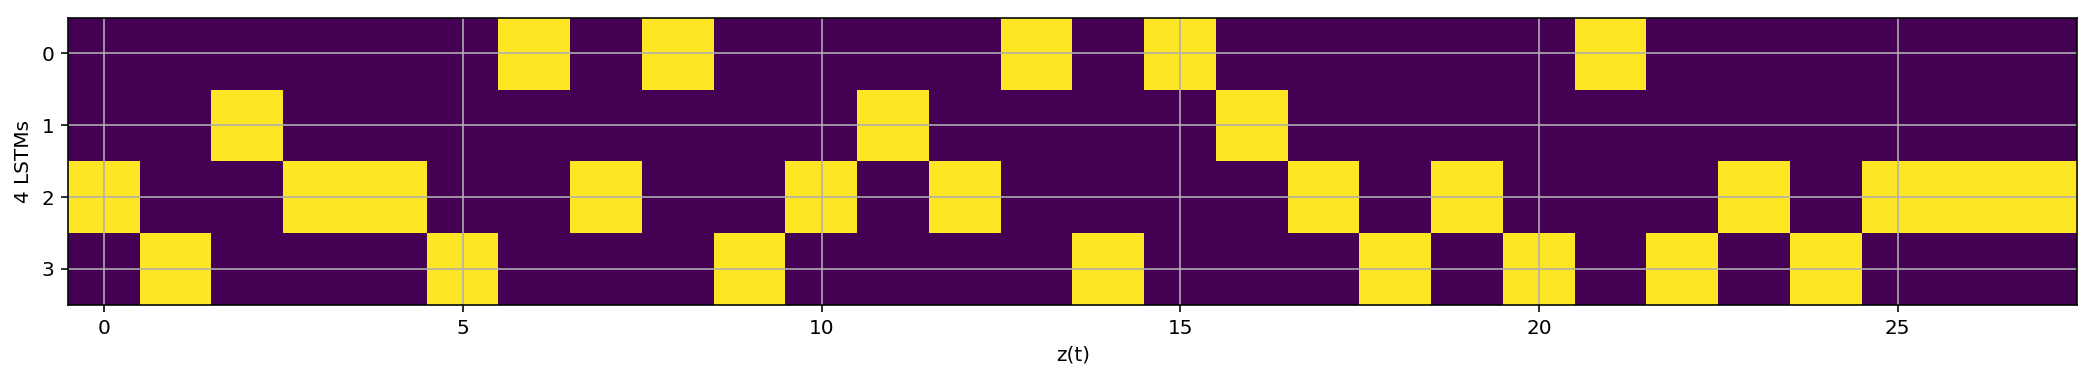

--------------------------------------------------------------------------------


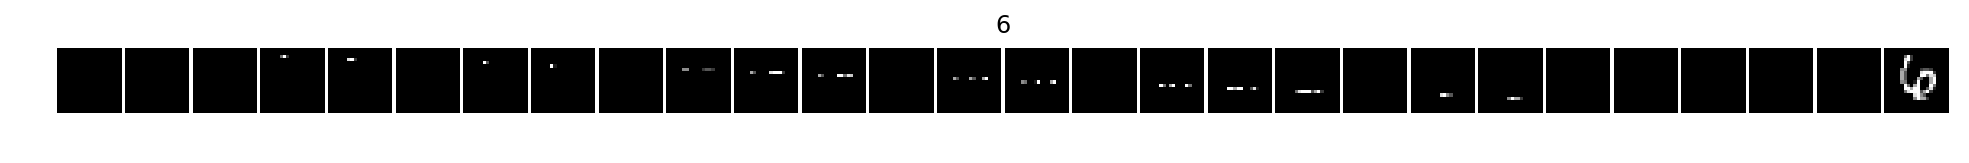

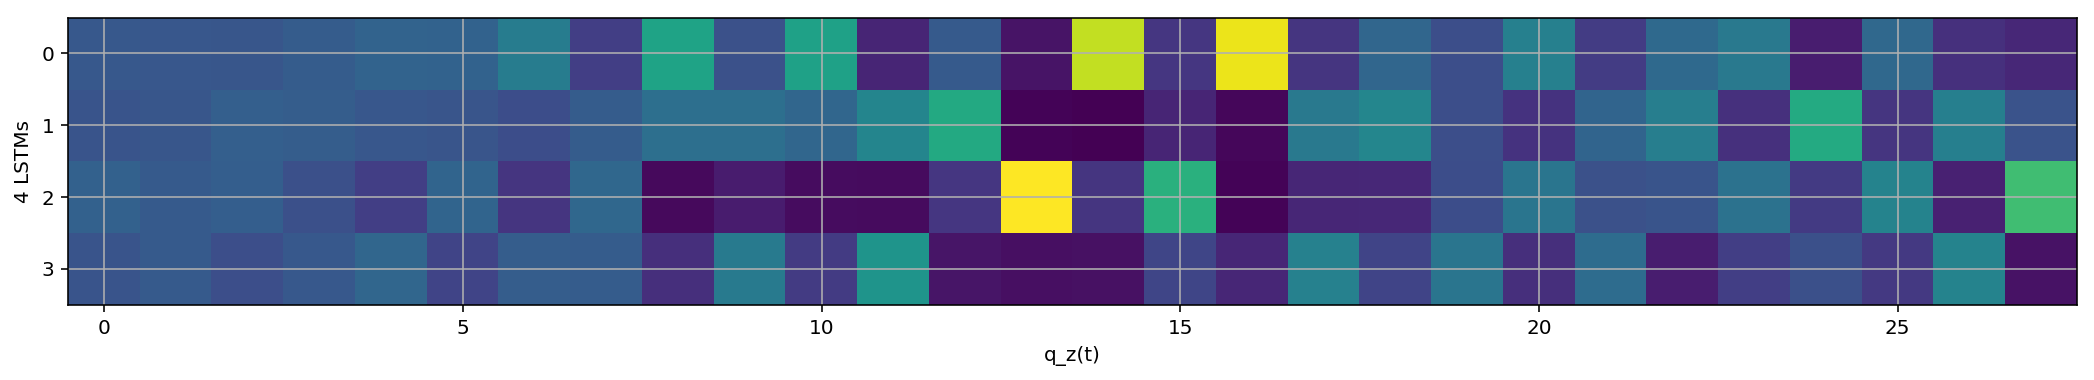

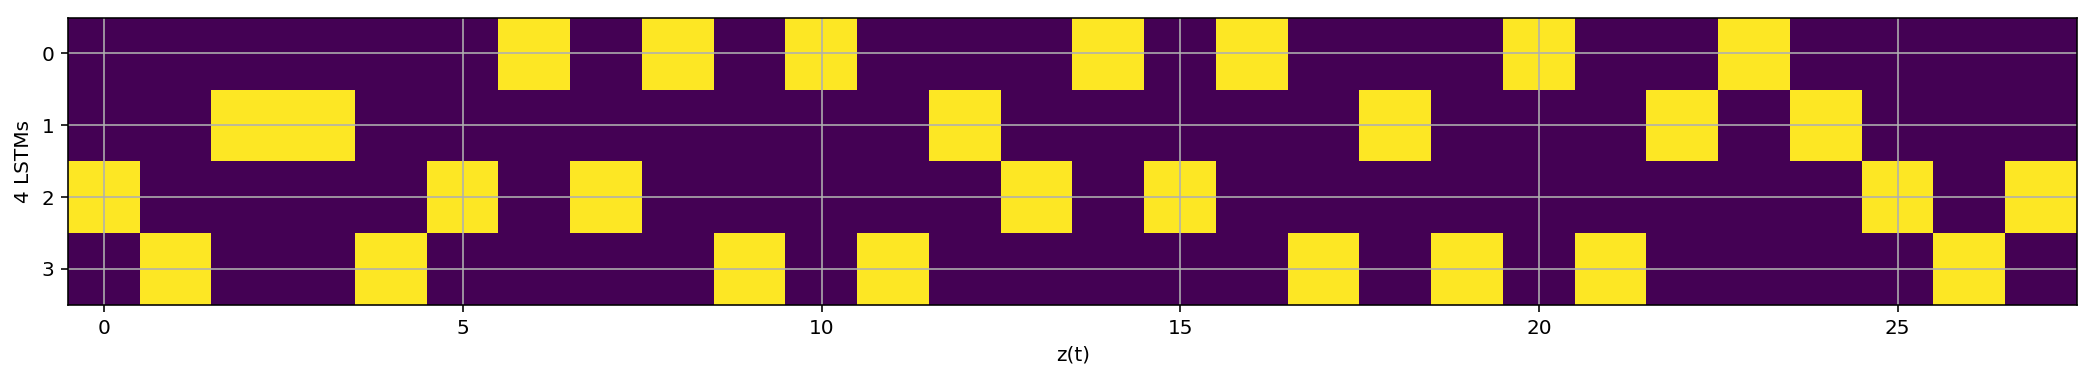

--------------------------------------------------------------------------------


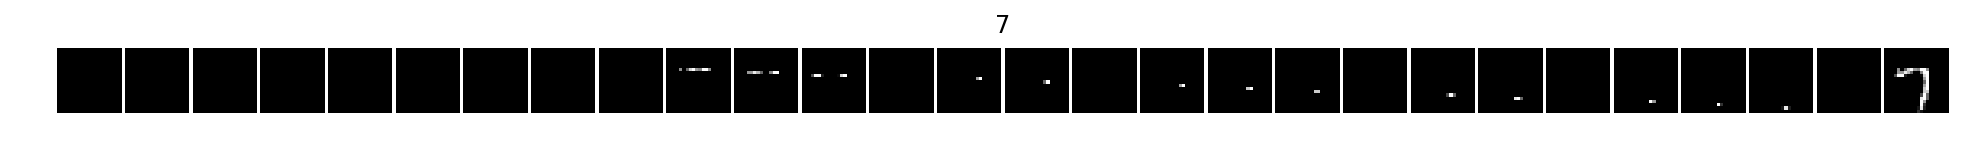

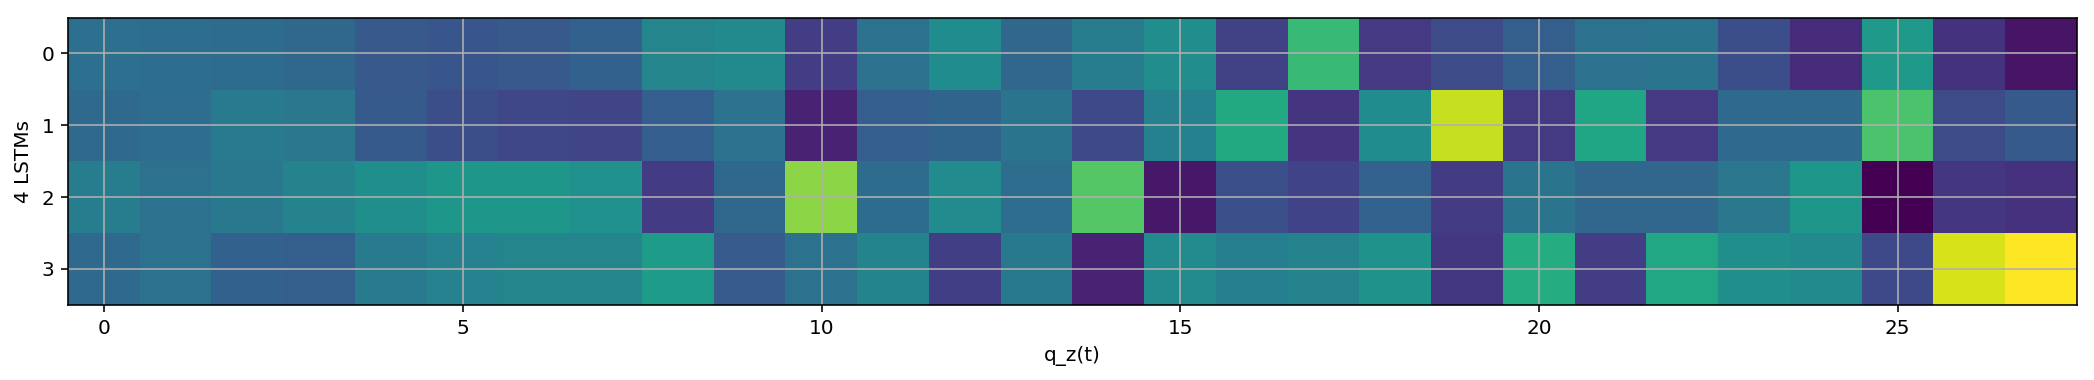

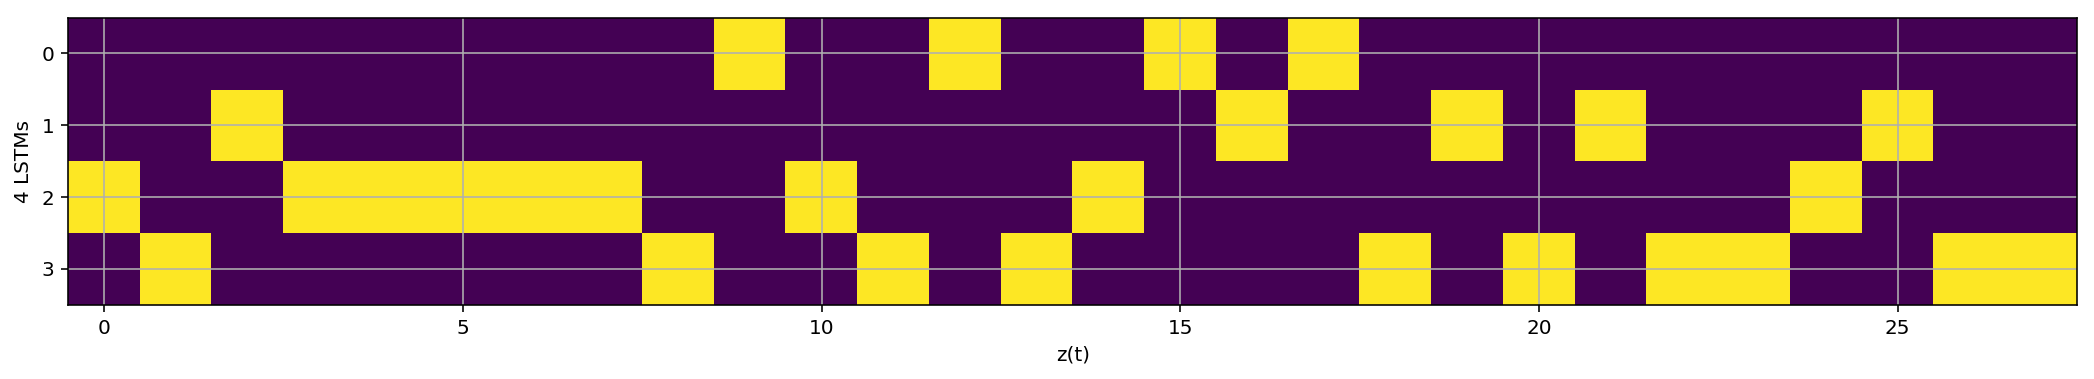

--------------------------------------------------------------------------------


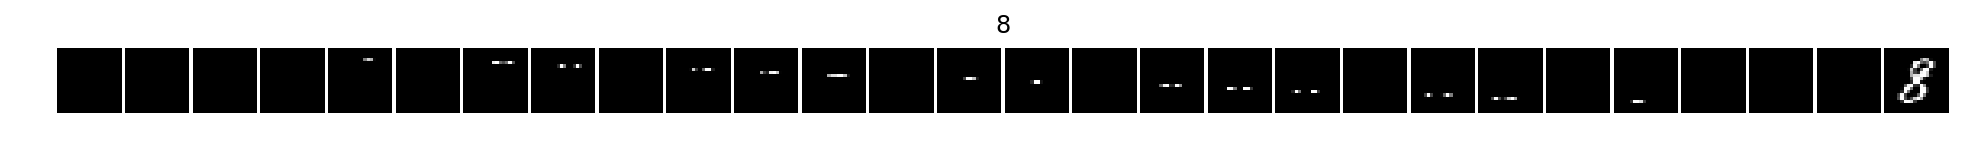

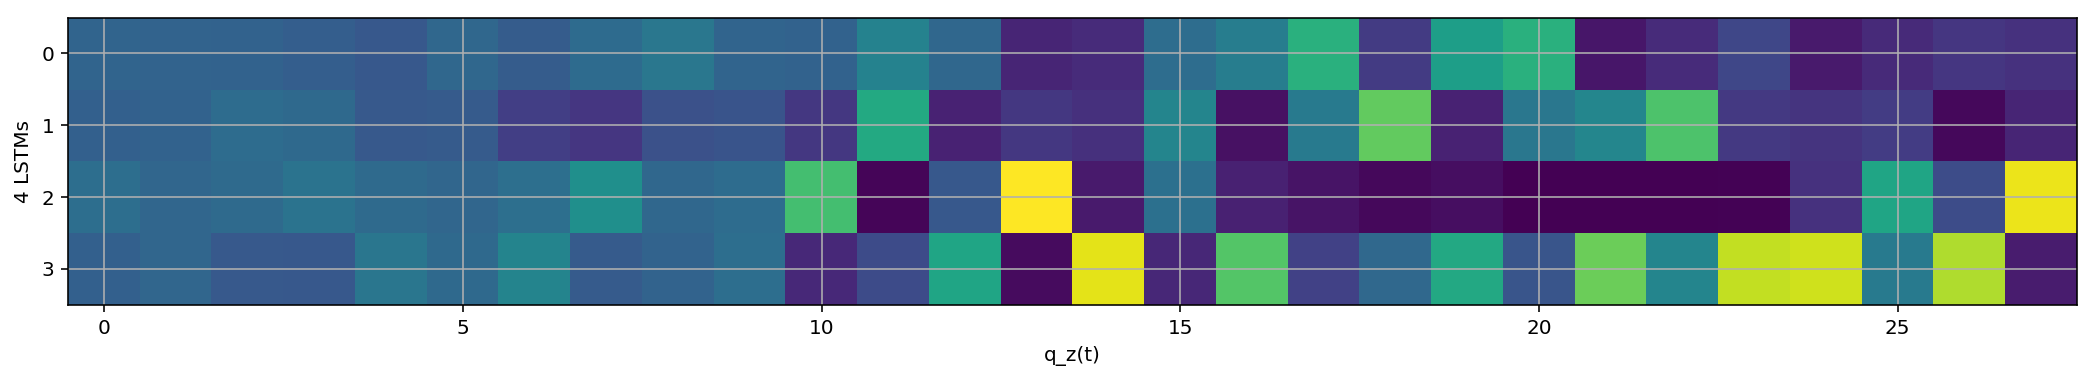

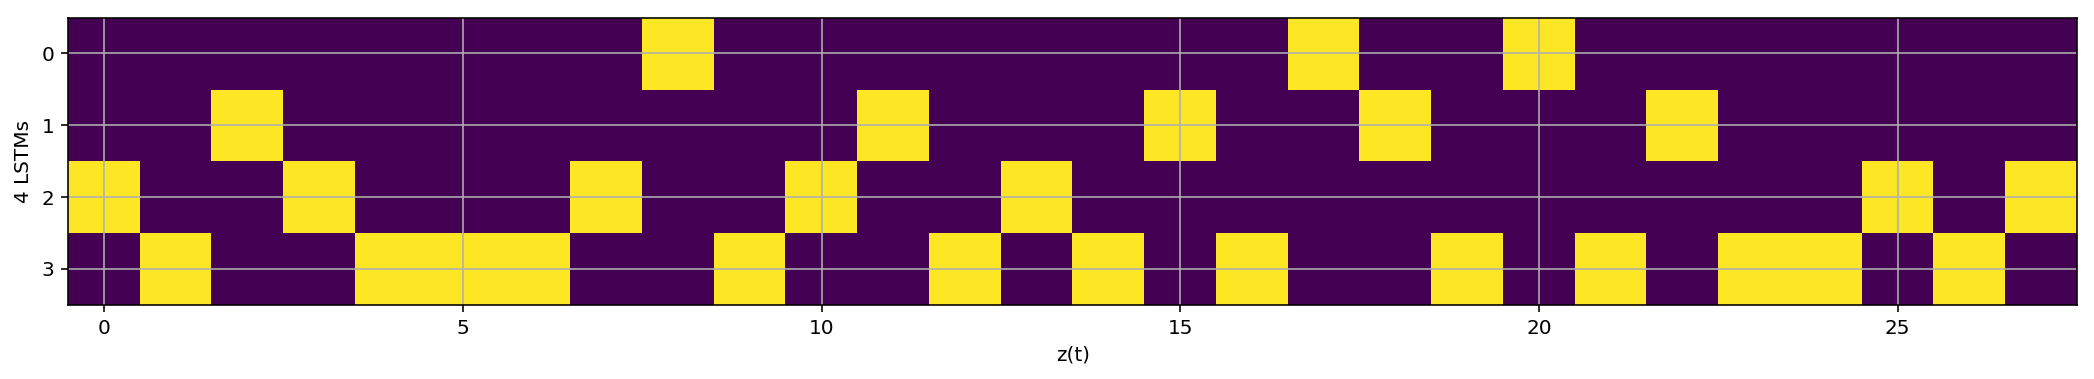

--------------------------------------------------------------------------------


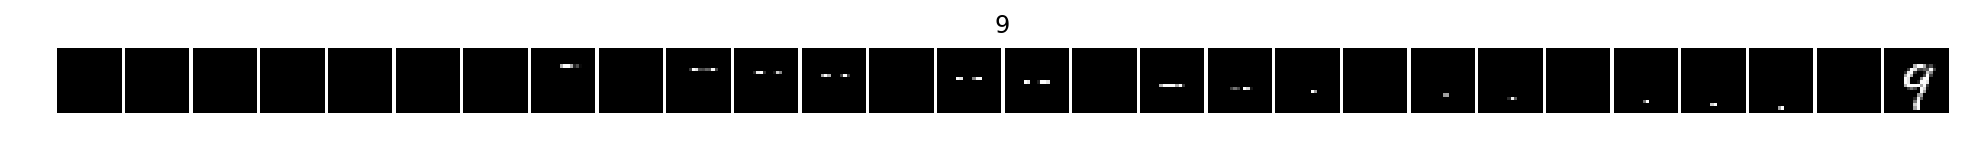

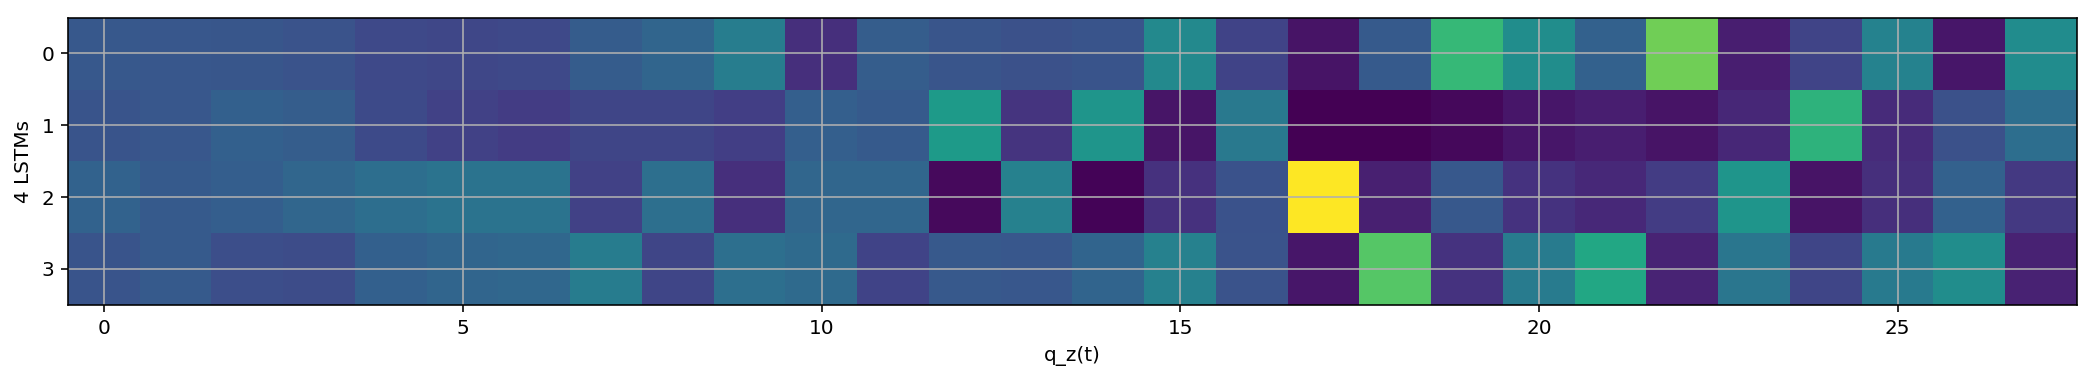

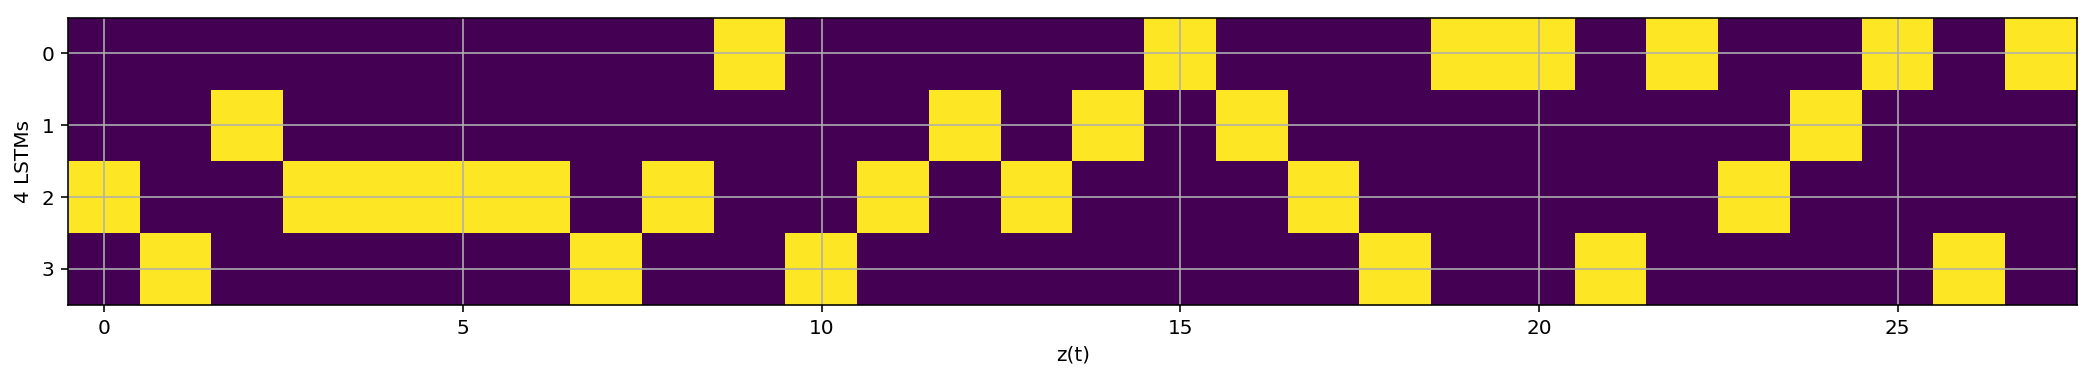

--------------------------------------------------------------------------------


In [7]:
random_pick = 2   # random pick a sample in the same category

# parameters for ploting image series
ncols, nrows = config.T, 1
photow, photoh = 20, 20
marl, mart, marr, marb = 1, 1, 1, 1
padding = True

for i in range(eval_config.num_class):
    # select samples of label y=i
    X_i, y_i = X[y == i, :].float() / 255, y[y == i]

    eval_config.batch_size = 5
    X_i, y_i = X_i[:eval_config.batch_size], y_i[:eval_config.batch_size]

    with torch.no_grad():
        output, layer_z_T, layer_qz_T, layer_h_T, _ = mrnn(X_i, eval_config.tau0, is_training=False)
    
    # plot MNIST digit as time series
    A = (X_i[random_pick].data.cpu().numpy() * 255).astype(np.uint8)
    frames = [np.zeros((config.T, config.T)).astype(np.uint8) for j in range(config.T)]
    for j in range(config.T):
        frames[j][j, :] = A[j, :]
    
    # print original image at the end
    frames[-1] = A
    
    # make image as series
    image_series = plot_image_series(frames, ncols, nrows, photow, photoh, marl, mart, marr, marb, padding)

    # plot 1: image (time) series
    plt.figure(figsize=(17, 15))
    plt.imshow(np.asarray(image_series))
    plt.axis('off')
    plt.title('{}'.format(i))
    # plt.savefig(os.path.join(output_folder, 'digit{}.png'.format(i)), dpi=600)
    plt.show()
    
    # plot 2: soft transition function: q_z(t)
    plt.figure(figsize=(18, 15))
    plt.imshow(layer_qz_T[random_pick].data.cpu().numpy().T)
    plt.xlabel('q_z(t)')
    plt.ylabel('{} LSTMs'.format(eval_config.K))
    plt.grid()
    # plt.savefig(os.path.join(output_folder, 'qz_t_digit{}.png'.format(i)), dpi=600)
    plt.show()

    # plot 3: Gumbel sampling of transition function: z(t)
    plt.figure(figsize=(18, 15))
    plt.imshow(layer_z_T[random_pick].data.cpu().numpy().T)
    plt.xlabel('z(t)')
    plt.ylabel('{} LSTMs'.format(eval_config.K))
    plt.grid()
    # plt.savefig(os.path.join(output_folder, 'z_t_digit{}.png'.format(i)), dpi=600)
    plt.show()
    
    print('-' * 80)